# pyfabric example 01 - fabric tensor of trabecular bone in the proximal femur

Created on:  25.10.2021 <br />
Last update: 05.11.2021 <br />

![](test_data/2000L_crop_imgaussfilt_101micron_uint8_YZ_fabric.png)

## Configuration

In [1]:
import os
import numpy as np
# import dxchange
import matplotlib
import matplotlib.pyplot as plt

# import mcubes
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes
# import ciclope
import pyfabric as pf
import pybonemorph as pbm
import pygalmesh

astropy module not found


In [2]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [3]:
%%html
<style>
table {float:left}
</style>

#### Read input data

In [3]:
input_file = '/home/gianthk/Data/2019.001.coop_TUberlin_simulierte_Mensch.iorig/2000L_crop_imgaussfilt_101micron_uint8/2000L_crop_imgaussfilt_101micron_uint8_0000.tif'

In [4]:
# Read 3D data
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*0.0101 # [mm]

3D image resize (optional)

In [5]:
factor = 3
# downsample with given factor
data_3D = ndimage.zoom(data_3D, 1/factor, output=None, order=2)

# correct voxelsize
vs = vs * factor

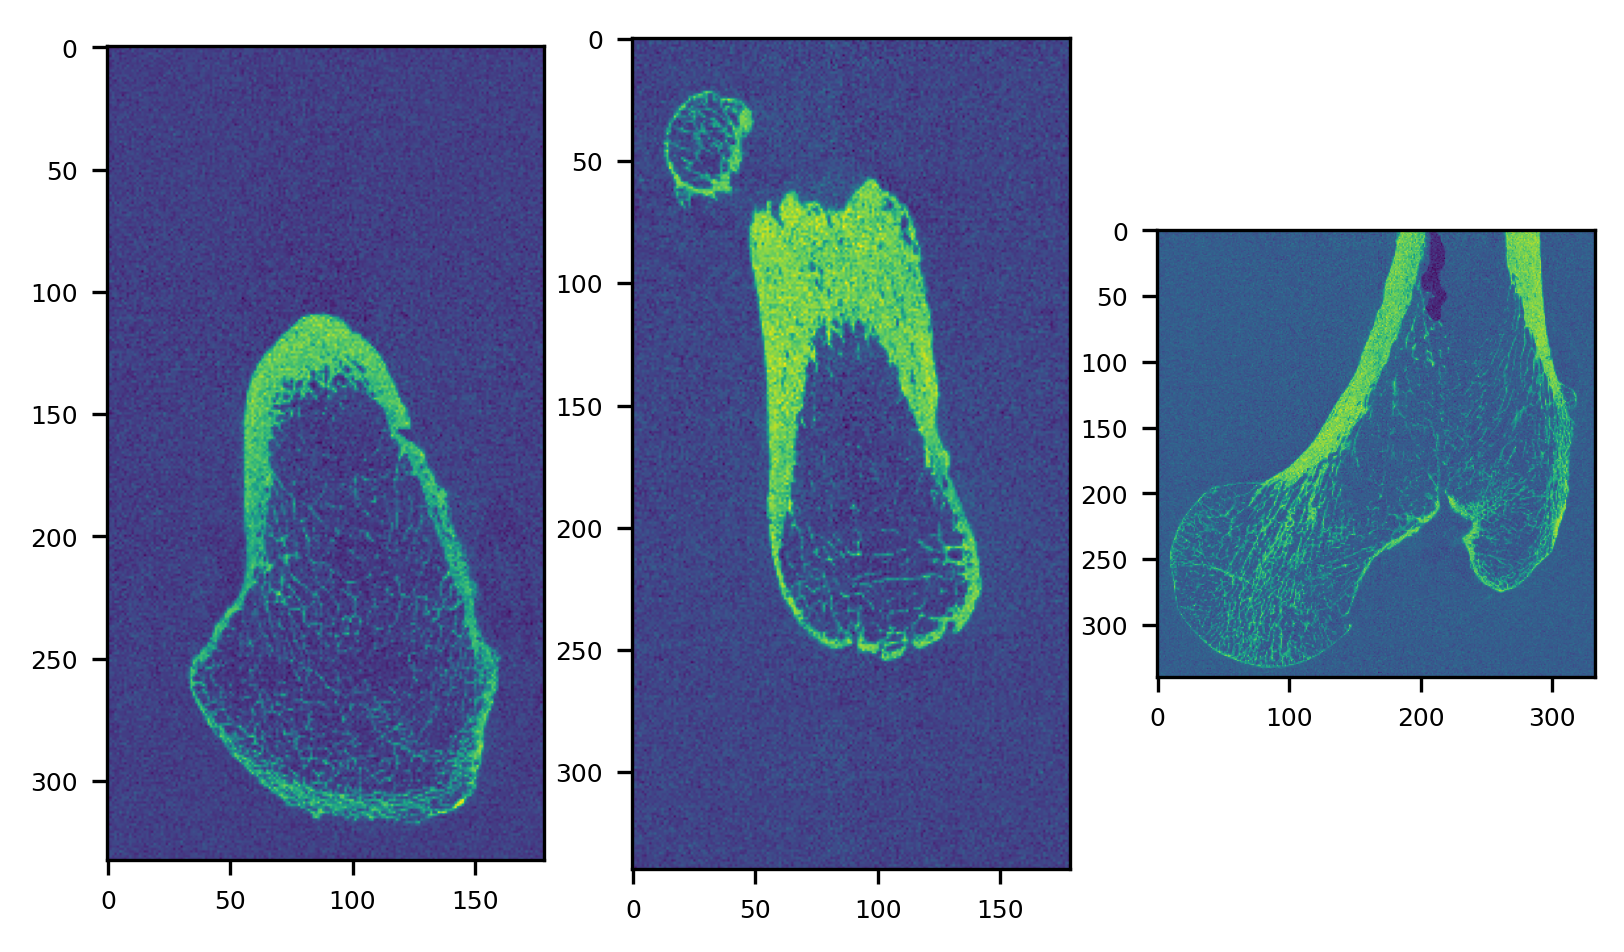

In [14]:
# Inspect dataset
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [6]:
import itk
from itkwidgets import view
viewer = view(data_3D, ui_collapsed=True)
viewer.interpolation = False

In [ ]:
# launch itk viewer
viewer

### Thresholding

In [7]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 142


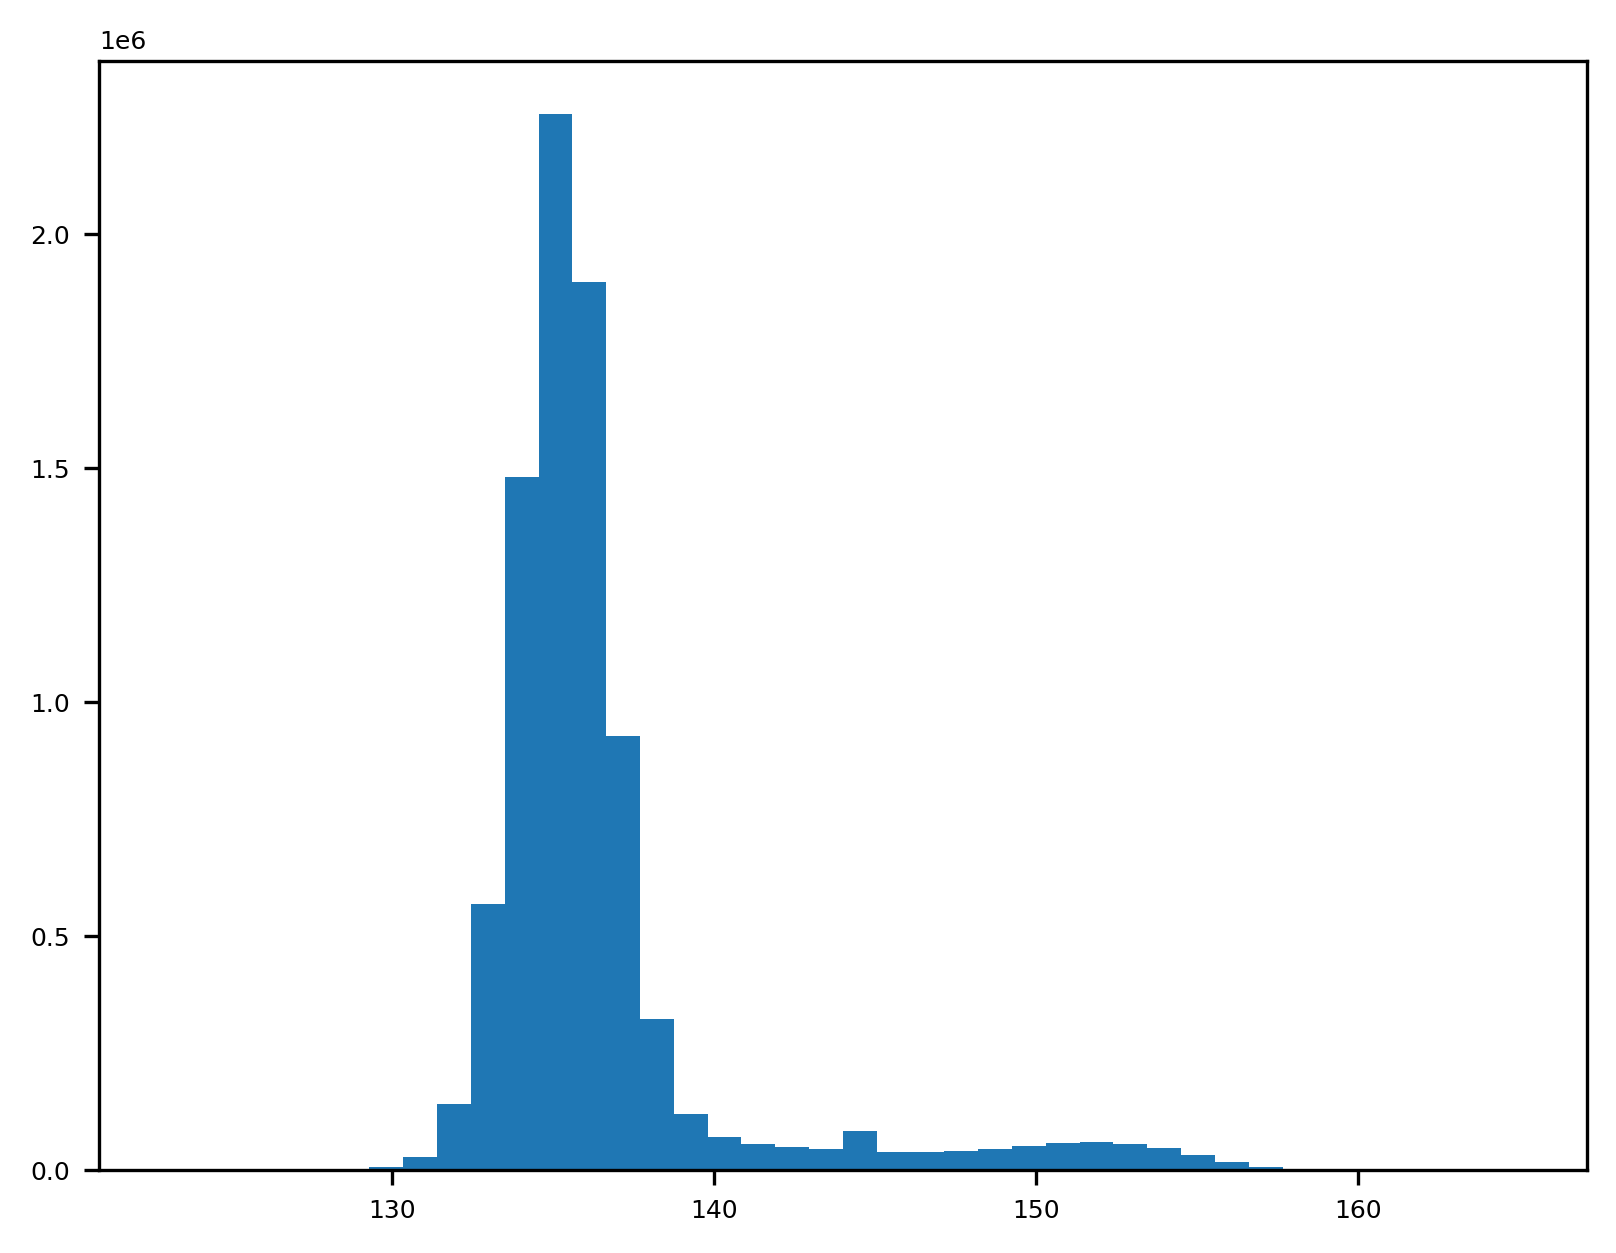

In [8]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

In [6]:
# apply the threshold
# BW = data_3D > T
BW = data_3D > 142

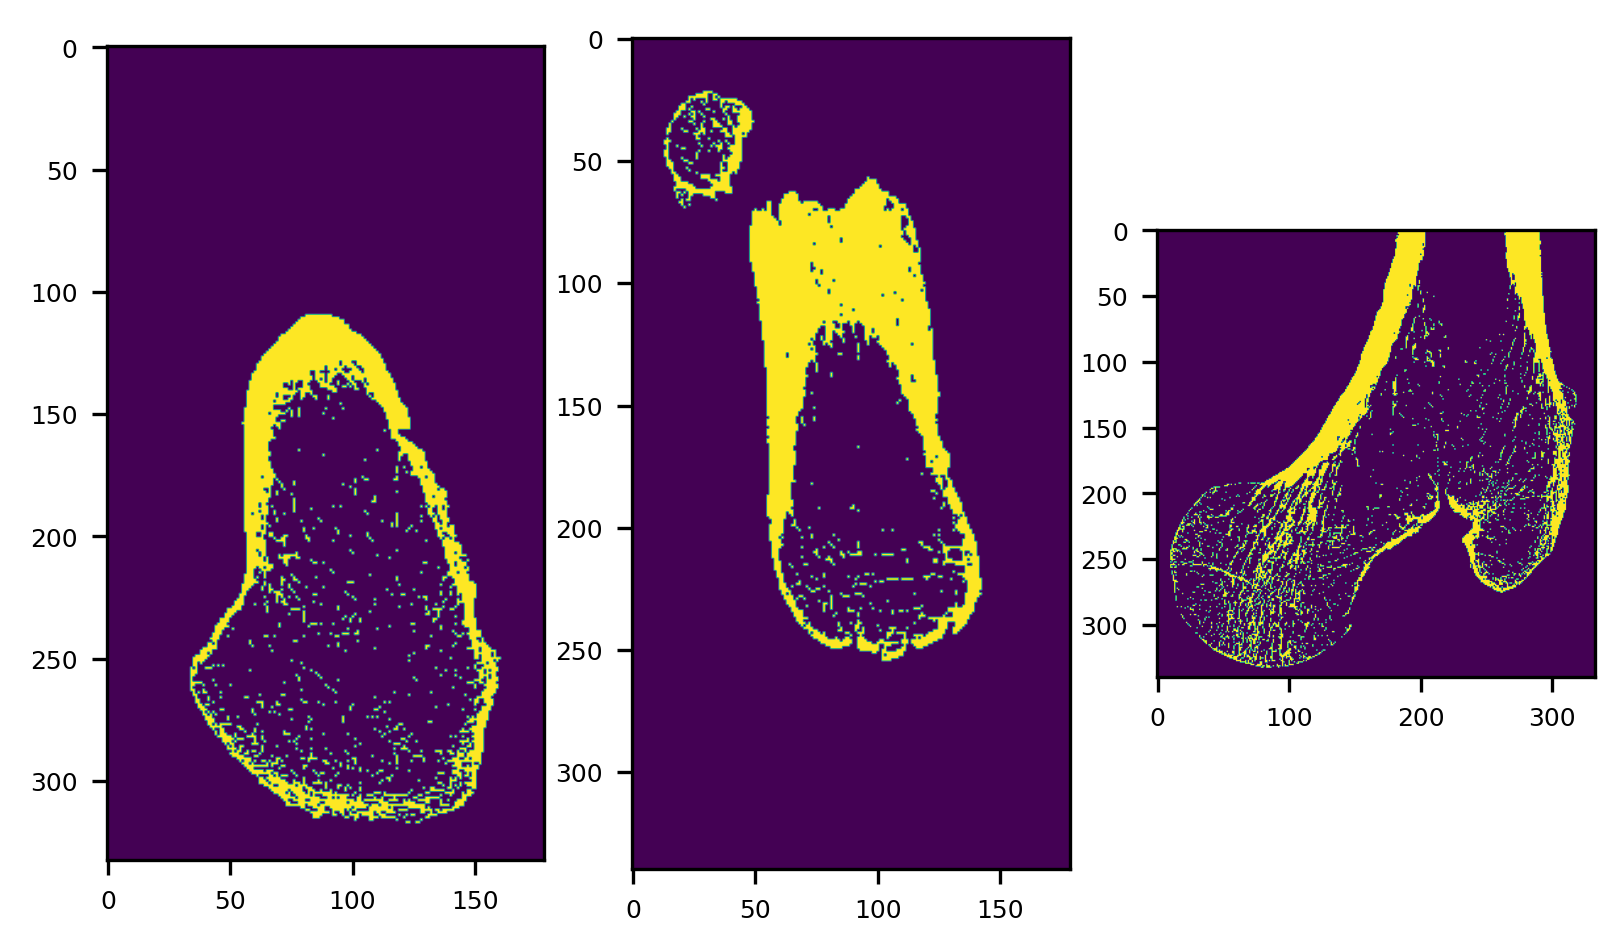

In [7]:
# Inspect binary mask
plot_midplanes(BW)
plt.show()

### Whole bone mask (periosteum mask)

In [22]:
BW_peri = pbm.periosteummask(BW, closepixels=8, closevoxels=10, remove_objects_smaller_than=1, removeunconn=True, verbose=True)

INFO:root:Preliminary removal of objects smaller than 1 pixels.
INFO:root:2D slice-wise image closing and filling.
 Structuring element DISK of radius: 8
100%|██████████| 340/340 [00:04<00:00, 84.55it/s]
INFO:root:Removing isolated clusters of voxels.
INFO:root:Final 3D image closing.
 Structuring element CUBE of radius: 8


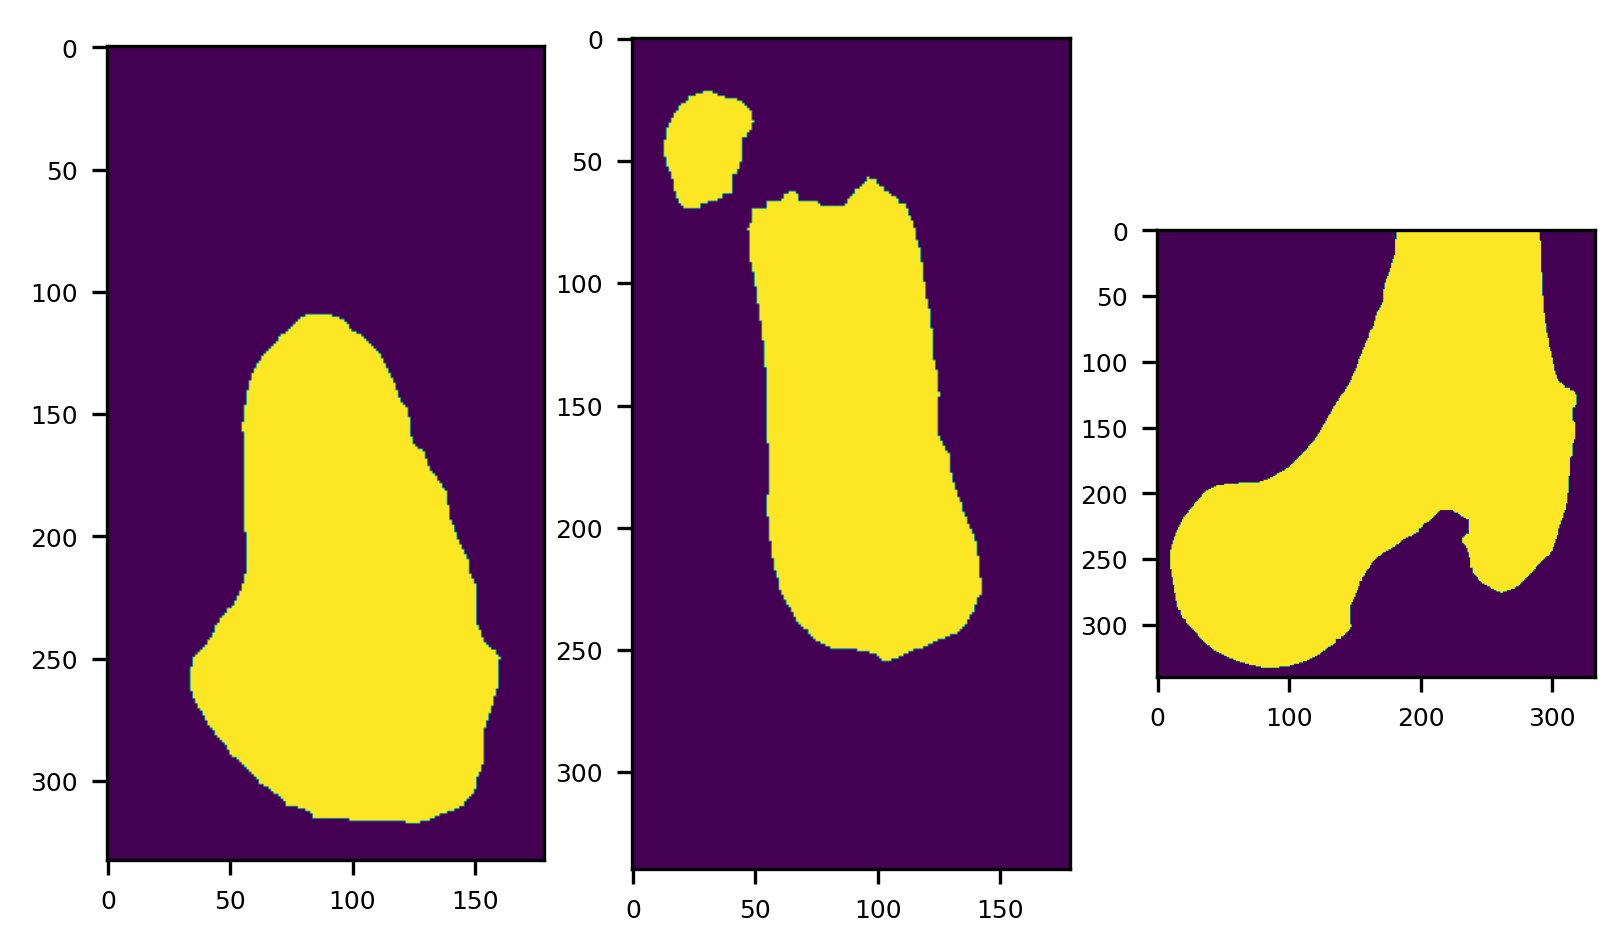

In [20]:
# Inspect whole bone mask
plot_midplanes(BW_peri)
plt.show()

### Cortical and trabecular bone masks
Not implemented yet.. we erode the whole bone mask instead to obtain a tentative mesh of the trabecular core

In [27]:
BW_trab = morphology.binary_erosion(BW_peri, morphology.cube(8))

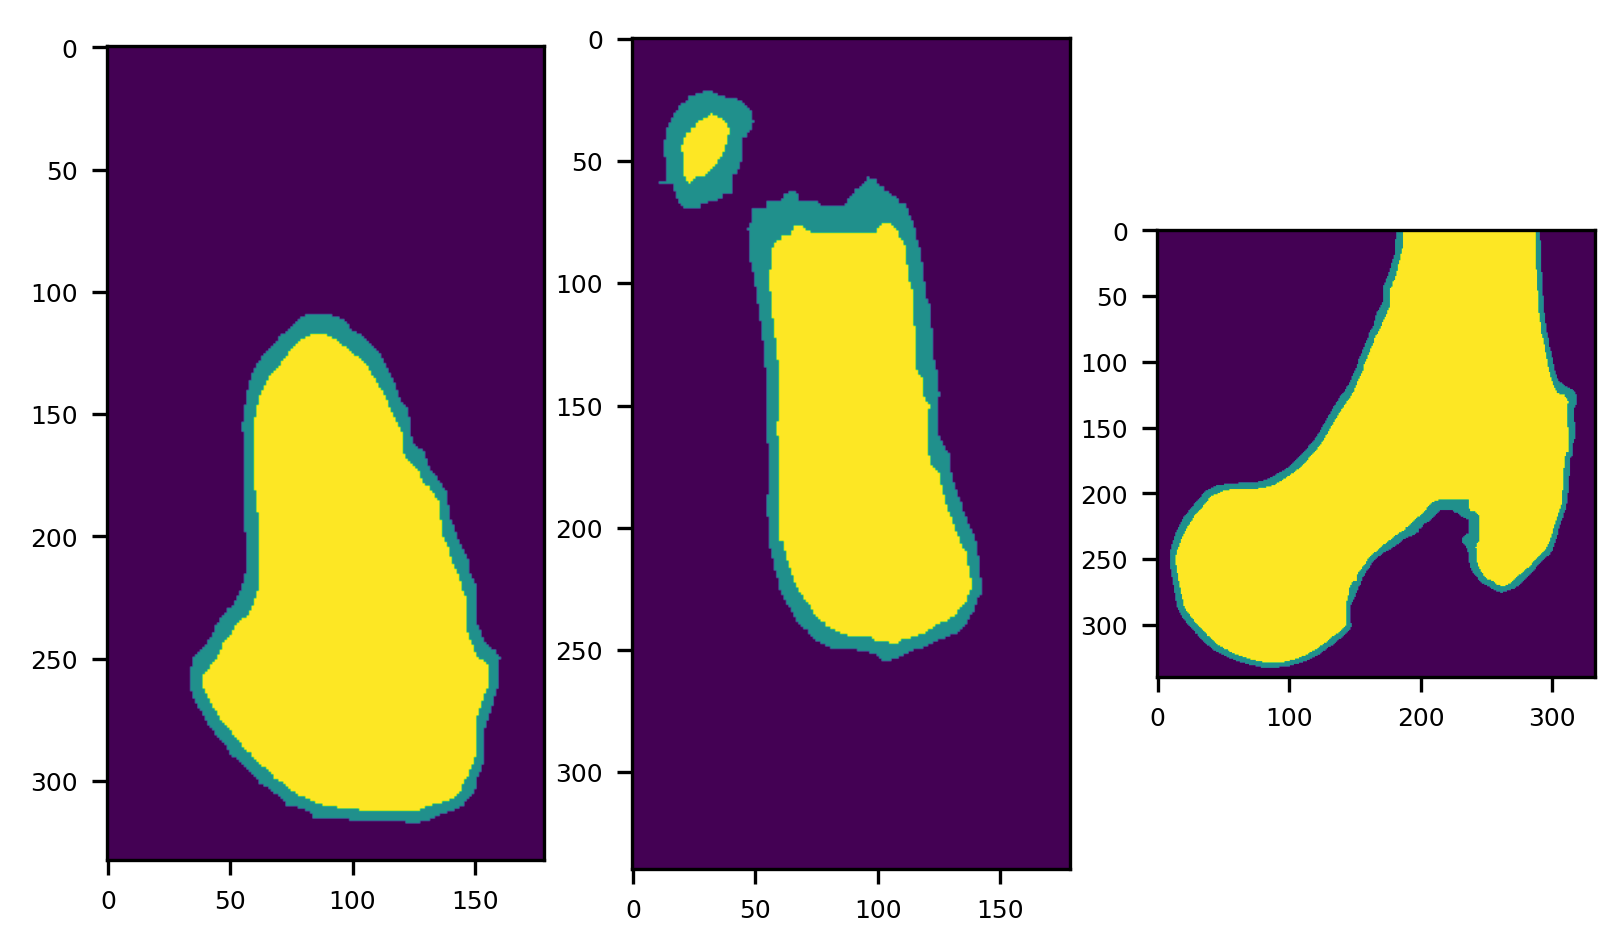

In [31]:
# Inspect mask
plot_midplanes(BW_trab.astype('int')+BW_peri.astype('int'))
plt.show()

In [23]:
import napari
viewer = napari.view_image()

/home/gianthk/anaconda3/envs/CT2FE/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


## Meshing
### Create tetrahedra mesh of trabecular core
Volume meshing is done using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [131]:
mesh_trab = pygalmesh.generate_from_array(np.transpose(BW_trab, [2, 1, 0]).astype('uint8'), tuple(vs), max_facet_distance=3*min(vs), max_cell_circumradius=15*1.2*min(vs))

Remove triangles

In [132]:
mesh_trab.remove_lower_dimensional_cells()

{'triangle'}

Write VTK mesh with [meshio](https://github.com/nschloe/meshio)

In [133]:
filename_mesh_out = '/home/gianthk/PycharmProjects/pyfabric/test_data/2000L_crop_imgaussfilt_101micron_uint8.vtk'

In [134]:
mesh_trab.write(filename_mesh_out)

#### Get Barycenter of each cell

In [139]:
# cells barycenter coordinates
cells_bary = np.sum(mesh_trab.points[mesh_trab.cells[0][1][:]], 1)/mesh_trab.points[mesh_trab.cells[0][1][:]].shape[1]

### Extract fabric information at cells barycenters

In [179]:
evecs, radii = pf.fabric_pointset(data_3D, cells_bary/vs[0], 20)

100%|██████████| 3289/3289 [00:03<00:00, 871.65it/s] 


Attach fabric cell data

In [180]:
mesh_trab.cell_data={'evec1': evecs[:,:,0], 'evec2': evecs[:,:,1], 'evec3': evecs[:,:,2], 'radii': radii}

Rewrite mesh

In [181]:
mesh_trab.write(filename_mesh_out)

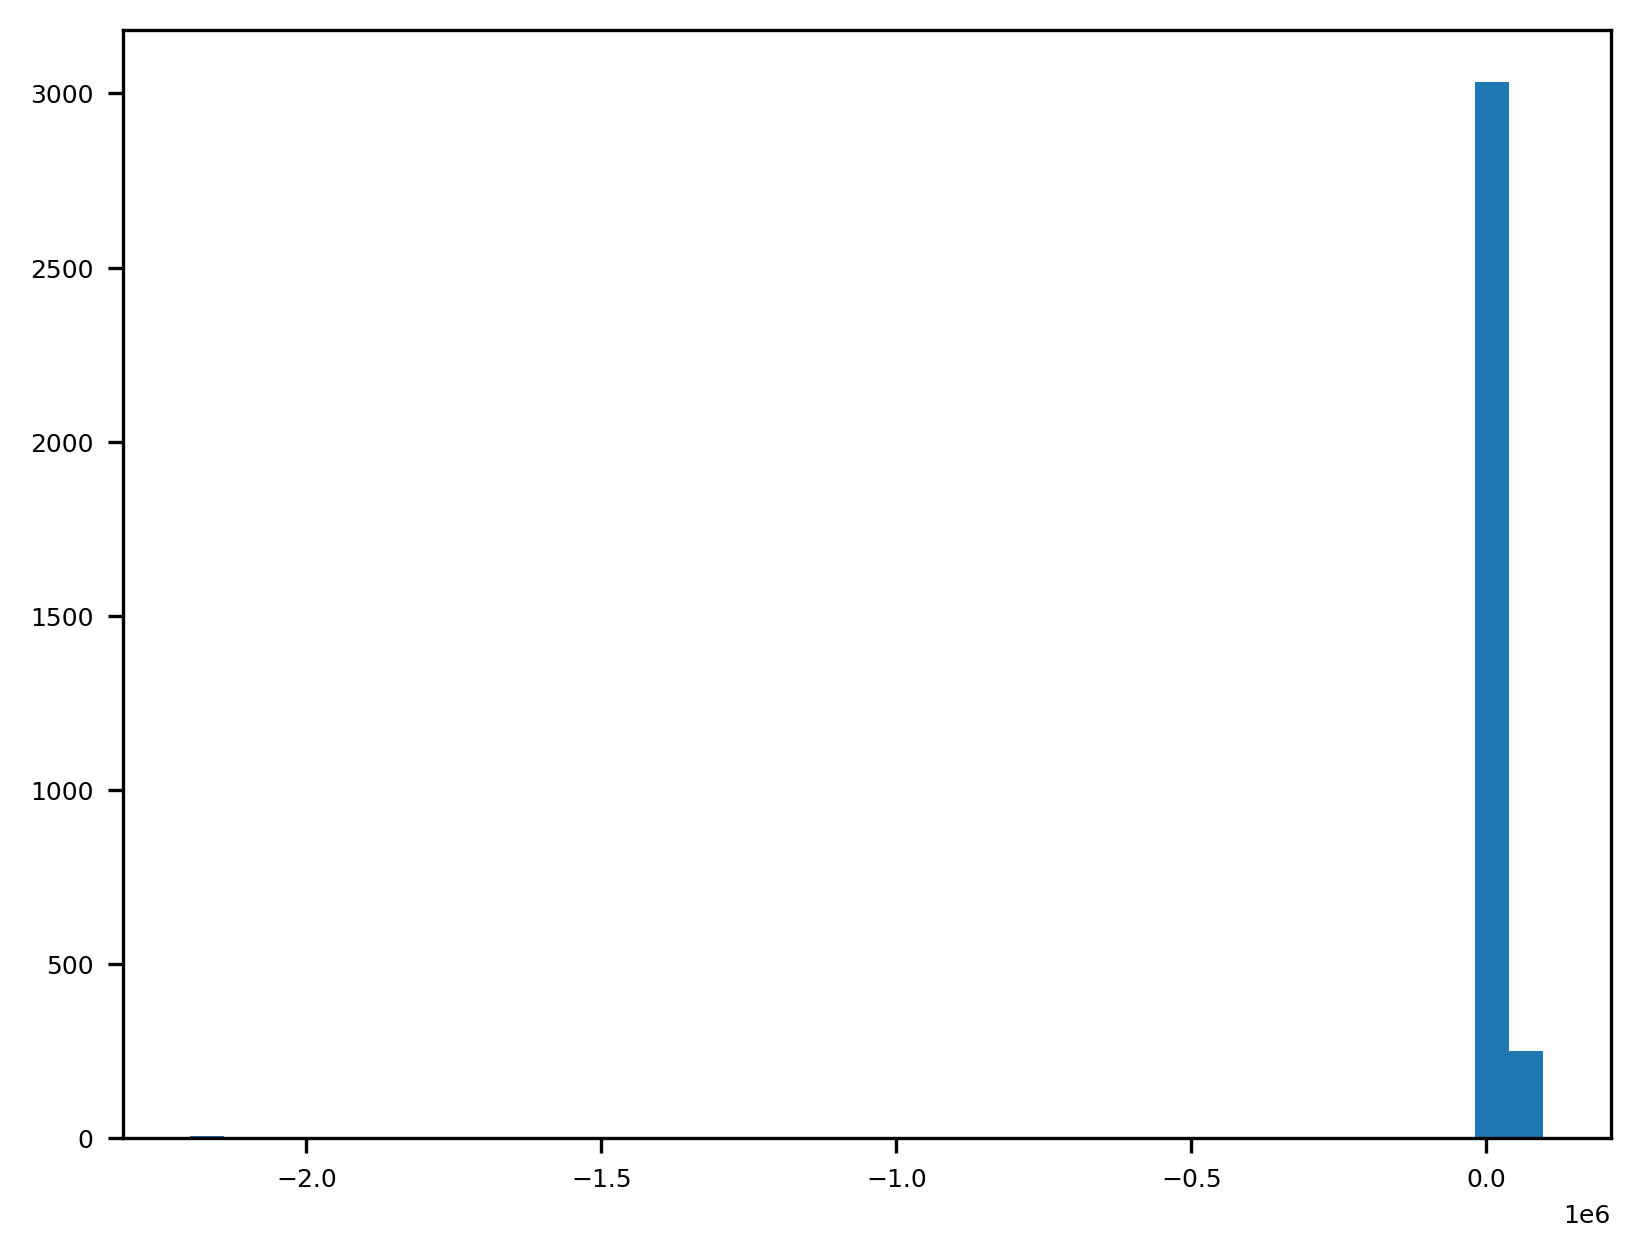

In [162]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(radii[:,1].ravel(), bins=40)
plt.show()

In [178]:
cells_bary/vs[0]

array([[ 92.62842 , 297.27206 , 210.53653 ],
       [137.10522 , 252.30962 , 182.79105 ],
       [140.95148 , 259.8531  , 141.9977  ],
       ...,
       [136.65637 , 234.66277 , 207.31676 ],
       [120.71544 , 195.40982 , 216.04855 ],
       [ 29.282185, 197.92068 ,  69.61635 ]], dtype=float32)

In [175]:
data_3D.shape

(340, 333, 179)

In [169]:
point = np.array([2.8, 3, 7])